In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [39]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True)
df.to_pickle('/tmp/df.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     29.251700     28.981150   
                          BTC     10532.400561  10596.176732  10451.465293   
                          ETH       221.191514    224.079639    221.015166   
                          XRP         0.319763      0.323658      0.319140   
2019-07-20 01:00:00+00:00 BNB        29.102050     30.051750     28.937300   
...                                        ...           ...           ...   
2022-09-02 08:00:00+00:00 ETH      1594.401429   1596.874286   1585.030000   
                          LINK        6.882598      6.912045      6.853060   
                          MATIC       0.881401      0.890773      0.880405   
                          SOL        31.624165     31.658390     31.415591   
                          XRP         0.331690      0.331690      0.330483   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        29.102300 2019-07-20 01:00:00+00:00   
                          BTC     10466.256172 2019-07-20 01:00:00+00:00   
                          ETH       221.450416 2019-07-20 01:00:00+00:00   
                          XRP         0.319678 2019-07-20 01:00:00+00:00   
2019-07-20 01:00:00+00:00 BNB        30.036500 2019-07-20 02:00:00+00:00   
...                                        ...                       ...   
2022-09-02 08:00:00+00:00 ETH      1590.434286 2022-09-02 09:00:00+00:00   
                          LINK        6.873536 2022-09-02 09:00:00+00:00   
                          MATIC       0.890107 2022-09-02 09:00:00+00:00   
                          SOL        31.562069 2022-09-02 09:00:00+00:00   
                          XRP         0.330670 2022-09-02 09:00:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB     0.063542  
                          BTC     0.034167  
                          ETH     0.034369  
                          XRP     0.043545  
2019-07-20 01:00:00+00:00 BNB     0.016383  
...                                    ...  
2022-09-02 08:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[245753 rows x 6 columns]

In [90]:
class ExampleModelRank2:
    def __init__(self):
        self._models = {}
        self._mods = [1, 4, 8, 24]
        for mod in self._mods:
            self._models[mod] = {}
            for hour in range(mod):
                self._models[mod][hour % mod] = Ridge(fit_intercept=False, alpha=1e5)
                # self._models[mod][hour] = lgb.LGBMRegressor(
                #     n_estimators=1000,
                #     learning_rate=0.001,
                #     random_state=None,
                #     n_jobs=-1,
                # )
        self.max_data_sec = 7 * 24 * 60 * 60 # for predict script

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        
        for mod in self._mods:
            df['hour'] = df.index.get_level_values('timestamp').hour % mod
            for hour, df_hour in df.groupby('hour'):
                self._models[mod][hour].fit(df_hour[features], df_hour['ret_rank'])
        
        return self
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['position'] = 0.0
        for mod in self._mods:
            df['hour'] = df.index.get_level_values('timestamp').hour % mod
            for hour, df_hour in df.groupby('hour'):
                df.loc[df_hour.index, 'position_mod'] = self._models[mod][hour].predict(df_hour[features])
            df['position_mod'] = unbiased_rank(df.groupby('timestamp')['position_mod']) - 0.5
            df['position'] += df['position_mod']
        df['position'] /= len(self._mods)
        
        # df['position'] = np.sign(df['position'])
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        for i in [24, 48, 72]:
            df['feature_momentum_{}'.format(i)] = np.log(df['cl'] / df.groupby('symbol')['cl'].shift(i)).fillna(0)
        for i in [24, 48, 72]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

        # symbol_count = df.reset_index()['symbol'].unique().size
            
        for col in get_feature_columns(df):
            df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
            # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
            # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))

        return df
    
def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos
    
def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

return without cost statistics
mean 0.002384327640303352
std 0.017865829230140132
sharpe 0.13345742924044787
max drawdown 0.3180789264969633
return with cost statistics
mean 0.0015203835653016396
std 0.01787856700787299
sharpe 0.08503945336514526
max drawdown 0.31818392649696325


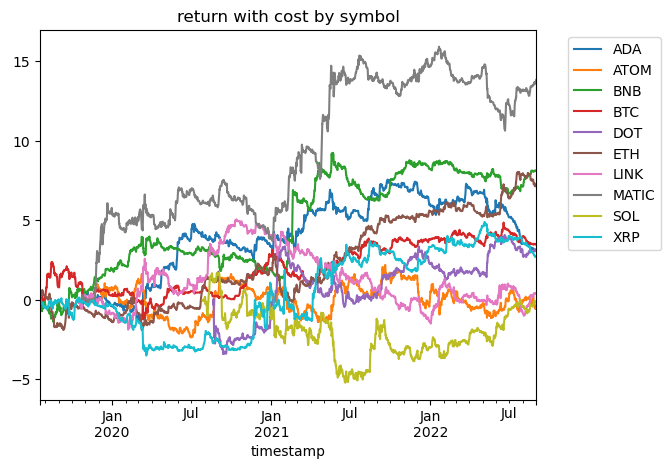

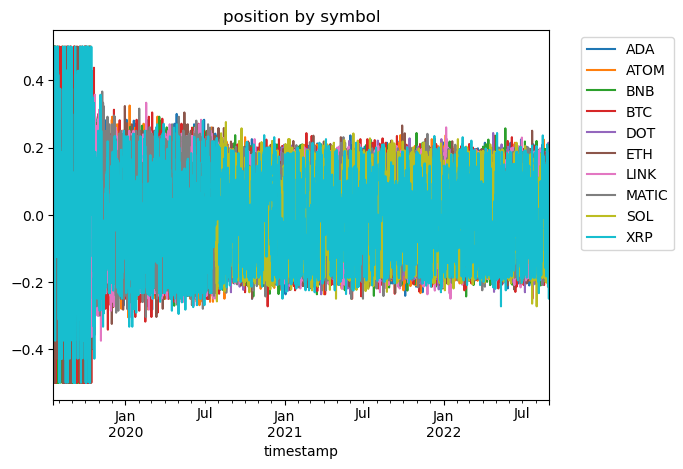

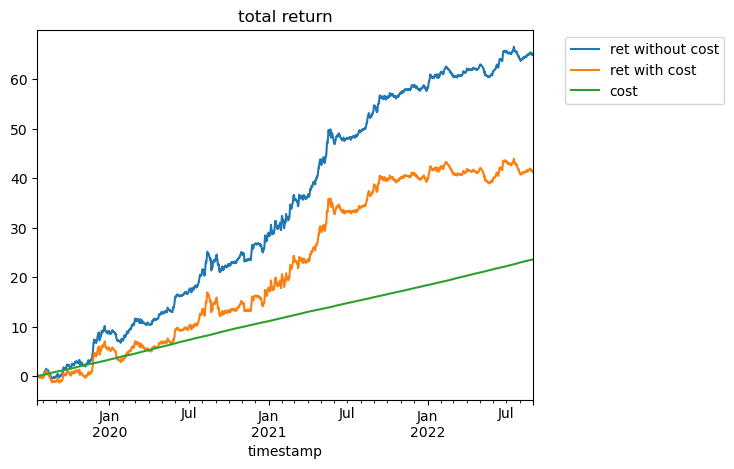

In [91]:
df = pd.read_pickle('/tmp/df.pkl')

model = ExampleModelRank2()

# cv
calc_position_cv(model, df)
visualize_result(df.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/example_model_rank2.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-08-26 08:00:00+00:00  ADA       0.00
                           ATOM      0.00
                           BNB       0.00
                           BTC       0.00
                           DOT       0.00
                                     ... 
2022-09-02 08:00:00+00:00  ETH      -0.02
                           LINK      0.10
                           MATIC     0.18
                           SOL      -0.14
                           XRP      -0.06
Name: position, Length: 1690, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


position1  position2  position3
timestamp                 symbol                                 
2022-08-26 09:00:00+00:00 ADA         -0.10      -0.10       0.00
                          ATOM        -0.10      -0.10       0.00
                          BNB          0.10       0.10       0.00
                          BTC          0.10       0.10       0.00
                          DOT          0.10       0.10       0.00
...                                     ...        ...        ...
2022-09-02 07:00:00+00:00 ETH          0.02       0.02       0.02
                          LINK         0.10       0.10       0.10
                          MATIC        0.18       0.18       0.18
                          SOL         -0.14      -0.14      -0.14
                          XRP         -0.06      -0.06      -0.06

[1670 rows x 3 columns]

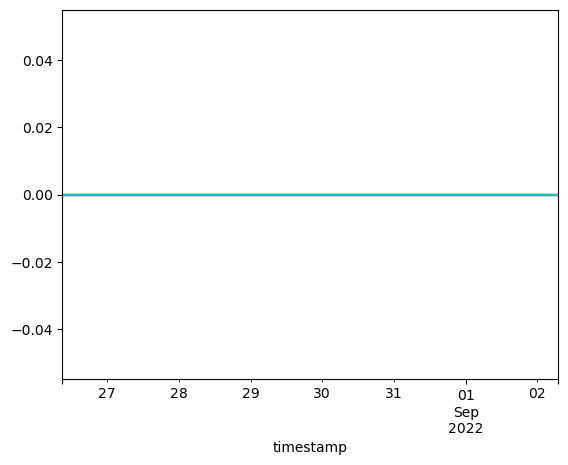

ADA (167, 4)
ATOM (167, 4)
BNB (167, 4)
BTC (167, 4)
DOT (167, 4)
ETH (167, 4)
LINK (167, 4)
MATIC (167, 4)
SOL (167, 4)
XRP (167, 4)


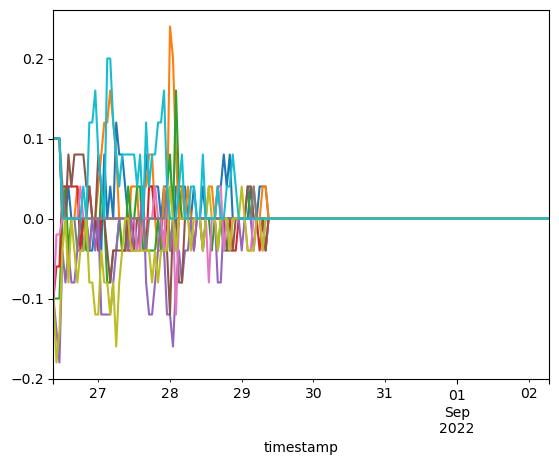

ADA (169, 3)
ATOM (169, 3)
BNB (169, 3)
BTC (169, 3)
DOT (169, 3)
ETH (169, 3)
LINK (169, 3)
MATIC (169, 3)
SOL (169, 3)
XRP (169, 3)


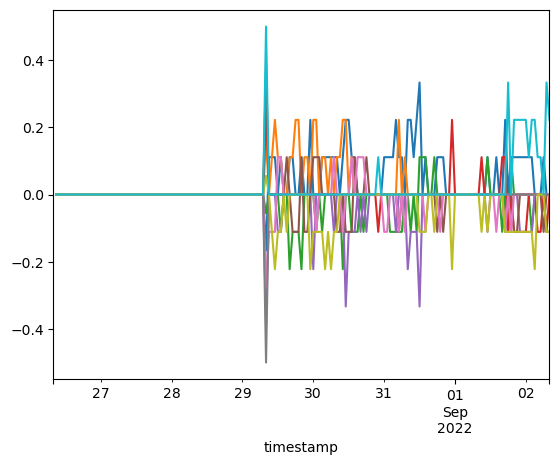

In [92]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/example_model_rank.xz')
df = pd.read_pickle('/tmp/df.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()